In [1]:
# !pip install python-gdcm -q
# !pip install pylibjpeg -q
# !pip install dicomsdl

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import os
import glob

from pathlib import Path




# Loading Dataset and Path for Train Images

In [2]:
filepath = '../data/train.csv'
patient_paths_training = '../data/train_images/'
data = pd.read_csv(filepath)
data.head(10)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False
7,2,10011,1031443799,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False
9,2,10025,1365269360,L,MLO,75.0,0,0,0,NaN,0,NaN,29,False


# Checking Information Related to each Column

### Number of Images

In [3]:
print(f'\n Exploring the Dataset:')
print(f'The number of images from Site 1 is { data.site_id.value_counts().values[0] }')
print(f'The number of images from Site 2 is { data.site_id.value_counts().values[1] }')
print(f'The number of unique patients is {data.patient_id.nunique()}')
print(f'The number of unique images is {data.image_id.nunique()}')
print('\n Images per patient, Statistics:')
print(data.groupby('patient_id')['image_id'].count().describe())


 Exploring the Dataset:
The number of images from Site 1 is 29519
The number of images from Site 2 is 25187
The number of unique patients is 11913
The number of unique images is 54706

 Images per patient, Statistics:
count    11913.000000
mean         4.592126
std          1.133216
min          4.000000
25%          4.000000
50%          4.000000
75%          5.000000
max         14.000000
Name: image_id, dtype: float64


### Laterality

Note that we have more images of the right breast than images of the left breast. Are there patients without images of the left breast? 

In [4]:
data.laterality.value_counts()

R    27439
L    27267
Name: laterality, dtype: int64

In the following cell, I am counting how many of R and L views have each patient. Therefore, the dataframe data.grouby('patient_id')['laterality'].value_counts() has for EACH patient the number of instances R and L appears for them. When I apply describe, it will tell me the minimum amount for each instance. Note that all of the patients has at least 2 images of each breast. Therefore, the imaging is assumed to be performed at least two times on each breast, for each patient. 

This is rather weird. It would be important to <b> recheck</b> this claim.

In [5]:
data.groupby('patient_id')["laterality"].value_counts().unstack(fill_value=0).stack()

patient_id  laterality
5           L             2
            R             2
25          L             2
            R             4
28          L             2
                         ..
65526       R             2
65530       L             3
            R             3
65534       L             2
            R             2
Length: 23826, dtype: int64

### View

In [6]:
data.groupby('patient_id')["view"].value_counts().unstack(fill_value=0).stack()

patient_id  view
5           AT      0
            CC      2
            LM      0
            LMO     0
            ML      0
                   ..
65534       CC      2
            LM      0
            LMO     0
            ML      0
            MLO     2
Length: 71478, dtype: int64

In [7]:
data.view.value_counts()

MLO    27903
CC     26765
AT        19
LM        10
ML         8
LMO        1
Name: view, dtype: int64

The different views:

- MLO : Mediolateral oblique view. 
- CC  : craniocaudal view.
- AT  : axillary tail view.
- LM  : lateromedial view
- ML  : Mediolateral view.
- LMO : lateromedial oblique view. 

All of them are available and with examples through : https://radiopaedia.org/articles/mammography-views?lang=us


### Number of Images Per Patient

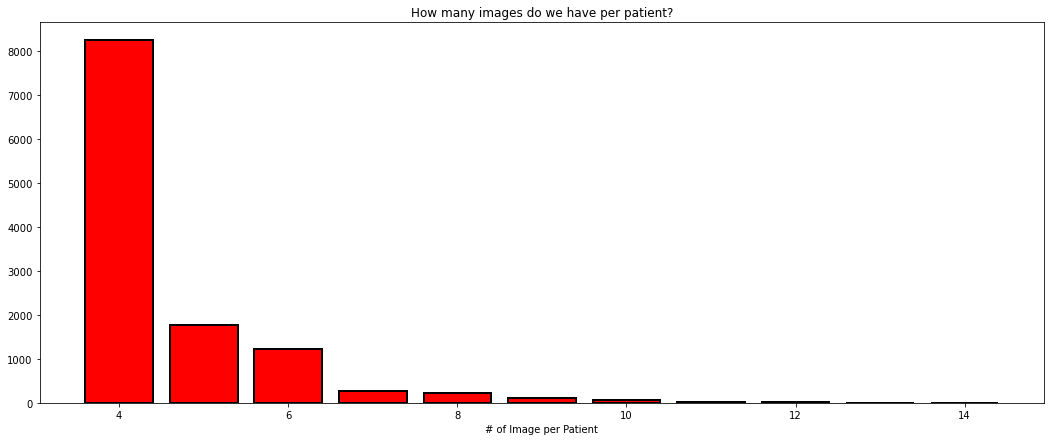

In [8]:
freq = data['patient_id'].value_counts().value_counts().values
bins = data['patient_id'].value_counts().value_counts().index.values
plt.figure(figsize = (18,7))
plt.bar(bins, freq, ec = 'k', lw = 2, fc = 'r')
plt.title('How many images do we have per patient?')
plt.xlabel('# of Image per Patient')
plt.show()

# Age:

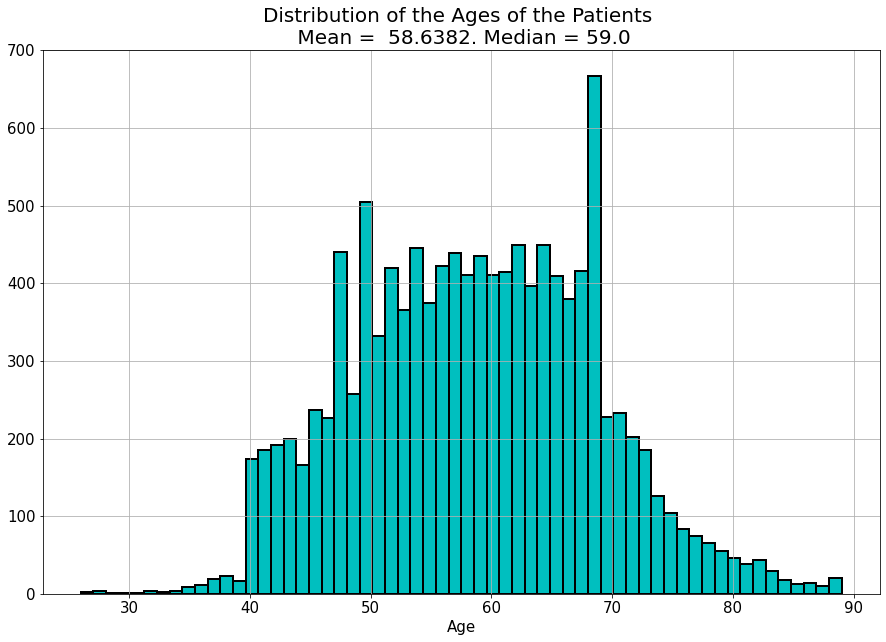

Oldest = 89.0
Youngest = 26.0


In [9]:
ages = data[data['age'].isna() == False].groupby('patient_id')['age'].apply(lambda x: x.unique()[0])
plt.figure(figsize=(15,10))
plt.hist(ages, bins=60, ec = 'k', lw = 2, fc = 'c')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Age', fontsize =15)
plt.grid()
plt.title(f'Distribution of the Ages of the Patients \n Mean = {ages.mean(): .4f}. Median = {ages.median()}', fontsize = 20)
plt.show()

print(f'Oldest = {ages.max()}')
print(f'Youngest = {ages.min()}')

Note that almost everyone is oldest than 40 years old. The mean and the median are almost the same. I would assume normality if necessary for statistical implementations. 

## Cancer Column:

On this column, we might be very careful with the amount of cancer and non-cancer entries. Usually, medical imaging tasks are heavily imbalanced, so we might expect this on this dataset. 

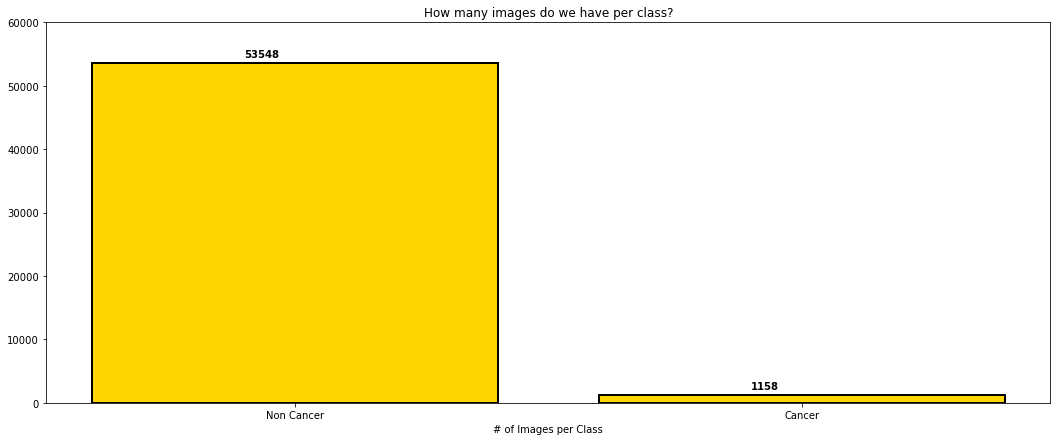

In [10]:
freq = data.cancer.value_counts().values
bins = data.cancer.value_counts().index
plt.figure(figsize = (18,7))
plt.bar(bins, freq, ec = 'k', lw = 2, fc = 'gold')
plt.title('How many images do we have per class?')
plt.xlabel('# of Images per Class')
plt.xticks([0,1], ['Non Cancer', 'Cancer'])
plt.ylim(0, 60000)
for i, v in enumerate(freq):
    plt.text(bins[i] - 0.1, v +1000, str(v), color = 'k', fontweight = 'bold')
plt.show()

As can be seen, 53548 images are labeled as non-cancerous, whereas 1158 are labeled as cancerous.

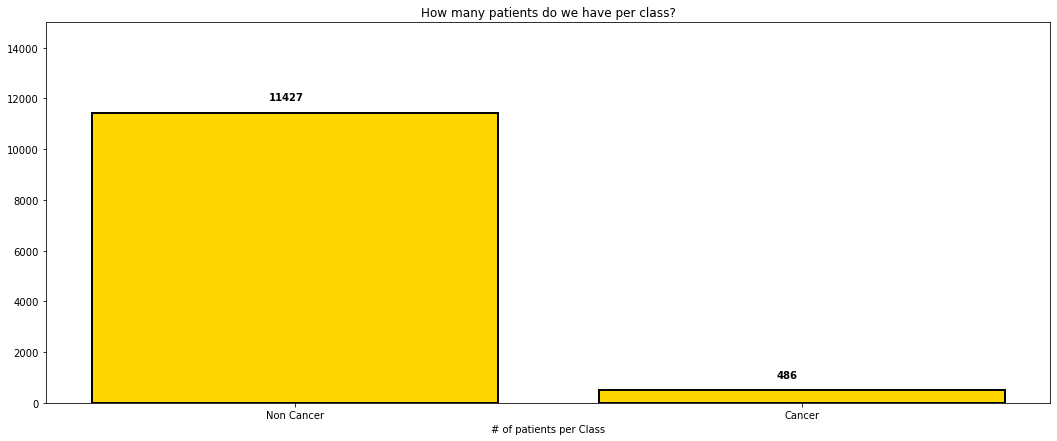

In [11]:
# For the following code, I give credit to: https://www.kaggle.com/code/allunia/rsna-breast-cancer-eda
# That is a wonderful and beautiful notebbok!

def has_cancer(l):
    if len(l) == 1:
        if l[0] == 0:
            return False
        elif l[0] == 1:
            return True
        else:
            raise Exception
    elif len(l) == 2:
        return True
    else:
        raise Exception

patient_cancer_map = data.groupby('patient_id').cancer.unique().apply(lambda l: has_cancer(l))


# ---------------------
freq = patient_cancer_map.value_counts().values
bins = patient_cancer_map.value_counts().index
plt.figure(figsize = (18,7))
plt.bar(bins, freq, ec = 'k', lw = 2, fc = 'gold')
plt.title('How many patients do we have per class?')
plt.xlabel('# of patients per Class')
plt.xticks([0,1], ['Non Cancer', 'Cancer'])
plt.ylim(0, 15000)
for i, v in enumerate(freq):
    plt.text(bins[i] -.05, v +500, str(v), color = 'k', fontweight = 'bold')
plt.show()

### Are there patients with Cancer and Non-Cancer tags? 

In [12]:
train_agg_df = data.groupby(["patient_id", "cancer"])["image_id"].count().reset_index()
train_agg2_df = train_agg_df.groupby(["patient_id"])["cancer"].count().reset_index()
train_agg2_df.cancer.value_counts()

1    11433
2      480
Name: cancer, dtype: int64

## Implant Column

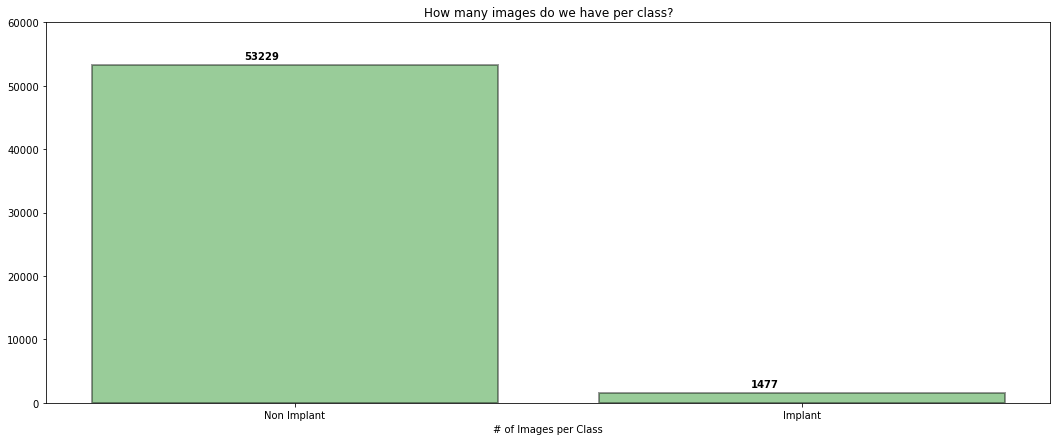

In [13]:
freq = data.implant.value_counts().values
bins = data.implant.value_counts().index
plt.figure(figsize = (18,7))
plt.bar(bins, freq, ec = 'k', lw = 2, fc = 'g', alpha = .4)
plt.title('How many images do we have per class?')
plt.xlabel('# of Images per Class')
plt.xticks([0,1], ['Non Implant', 'Implant'])
plt.ylim(0, 60000)
for i, v in enumerate(freq):
    plt.text(bins[i] - 0.1, v +1000, str(v), color = 'k', fontweight = 'bold')
plt.show()

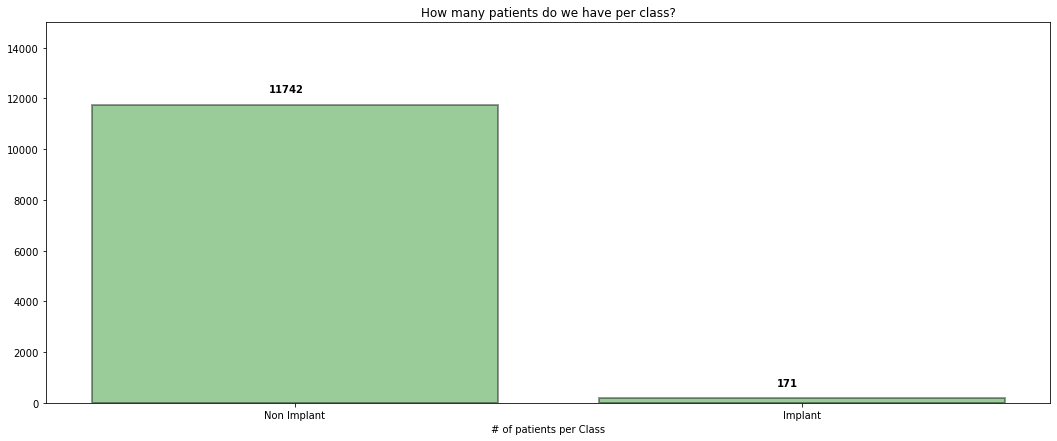

In [14]:
# For the following code, I give credit to: https://www.kaggle.com/code/allunia/rsna-breast-cancer-eda
# That is a wonderful and beautiful notebbok!

def has_cancer(l):
    if len(l) == 1:
        if l[0] == 0:
            return False
        elif l[0] == 1:
            return True
        else:
            raise Exception
    elif len(l) == 2:
        return True
    else:
        raise Exception

patient_cancer_map = data.groupby('patient_id').implant.unique().apply(lambda l: has_cancer(l))


# ---------------------
freq = patient_cancer_map.value_counts().values
bins = patient_cancer_map.value_counts().index
plt.figure(figsize = (18,7))
plt.bar(bins, freq, ec = 'k', lw = 2, fc = 'g', alpha = .4)
plt.title('How many patients do we have per class?')
plt.xlabel('# of patients per Class')
plt.xticks([0,1], ['Non Implant', 'Implant'])
plt.ylim(0, 15000)
for i, v in enumerate(freq):
    plt.text(bins[i] -.05, v +500, str(v), color = 'k', fontweight = 'bold')
plt.show()

Although we have more images with implants that images that actually exhibit some sort of Cancer, we may notice that we have less patients with implants (way less patients), that patients with cancer. Which implies that patients with implants may have more images taken from them, than patients without implants. This may imply that it is expected for some networks, to have problem identifying cancer on patients with implants. Specially with big implants. 

# Visualizing Images:

### Information that we have in a DCM (DICOM) file:

In [21]:
example = '../data/train_images/10006/1459541791.dcm'
example = pydicom.dcmread(example)
example.PhotometricInterpretation

'MONOCHROME1'

### Function for Plotting 4 images from a patient ID. 

The following function allows us to visualize 4 images from a patient ID. This is 

In [24]:
def plot_dicom(patient_id):
    patient_dir = os.path.join('../data/train_images', str(patient_id))
    n = len(os.listdir(patient_dir))
    print(f"Number of images for patient: {n}")
    fig, axs = plt.subplots(2, 2, figsize=(24,15))
    axs = axs.flatten()
    
    for i, img_path in enumerate(list(Path(patient_dir).iterdir())):
        ds = pydicom.dcmread(img_path)
        if ds.PhotometricInterpretation == 'MONOCHROME1':
            ds = 255 - ds.pixel_array
        else:
            ds = ds.pixel_array
        if i > 3:
            break
        axs[i].imshow(ds, cmap="bone")


# Example of a Cancerous image

Number of images for patient: 4


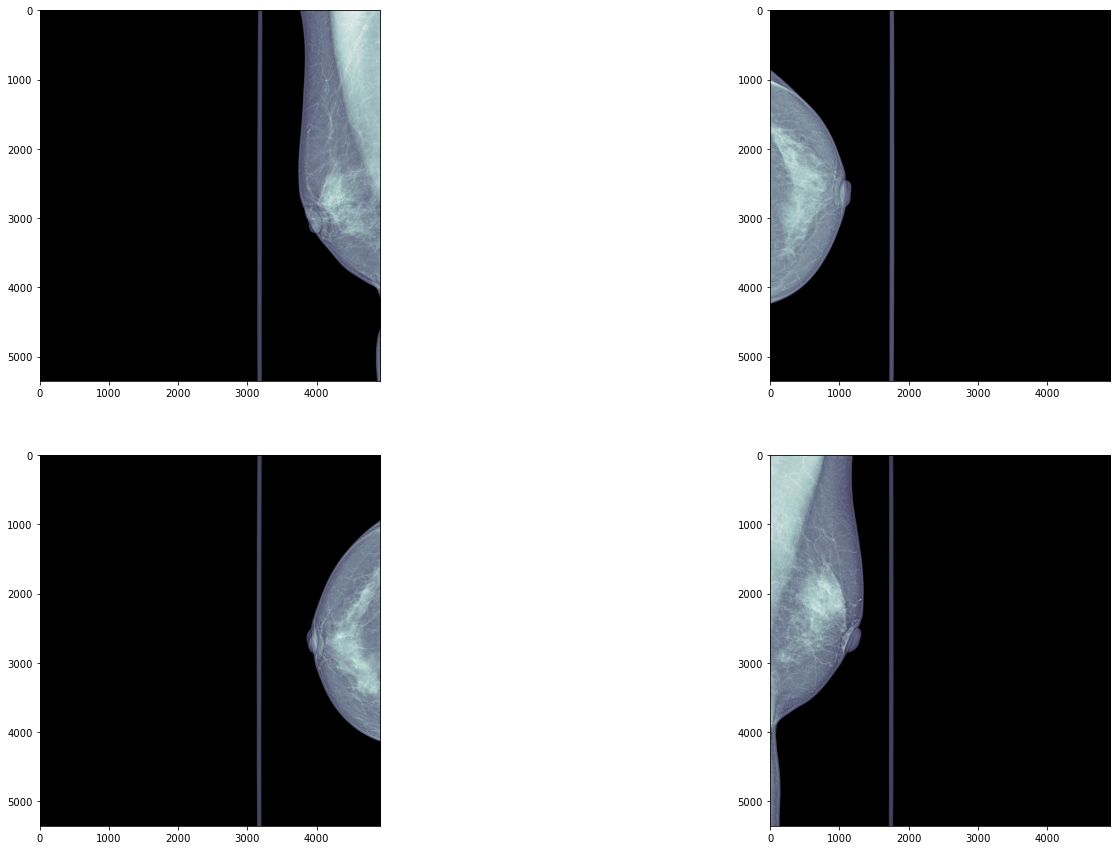

In [25]:
plot_dicom(data.patient_id[data.cancer == 0].iloc[0])

# Example of a Non-Cancerous image

Number of images for patient: 4


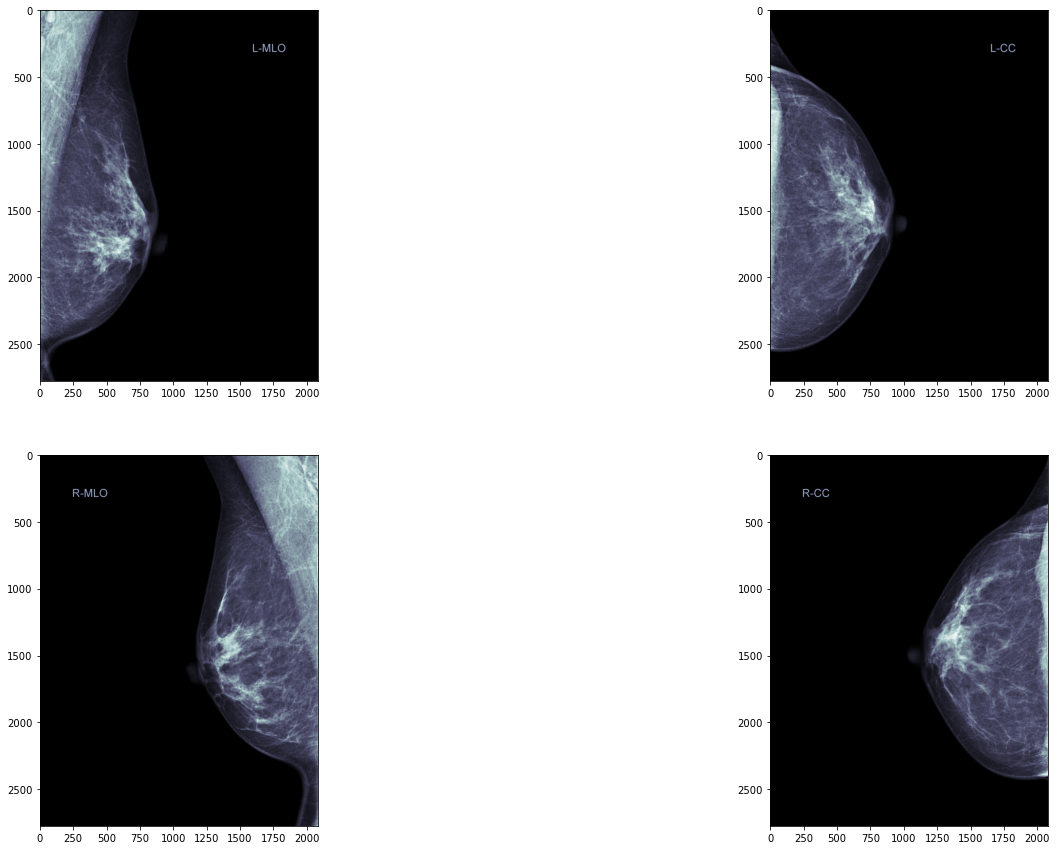

In [18]:
plot_dicom(data.patient_id[data.cancer == 0].iloc[5])